## Feature Engineering

*Feature Enginerring* — это процесс создания новых признаков или преобразования существующих, нацеленный на улучшение качества модели машинного обучения. Он включает в себя отбор значимой и актуальной информации из "сырых" данных и преобразования её в формат, понятный модели.

При этом важно иметь наглядное представление взаимосвязей между признаками в данных. Поскольку исследуя эти зависимости, мы можем конструировать новые полезные признаки, исключать вредные, правильно подбирать алгоритмы для решения задачи и так далее.

Проведём процесс Feature Engineering-а в задаче бинарной классификации.

Задача

У нас есть некоторые данные, где представлены объекты двух классов с метками «A» и «B», по условию задачи нам нужно получить модель на основе алгоритма логистической регрессии, которая позволит получить 100% долю правильных ответов.

### 1. Визуализация данных

Импортируем библиотеки

*pandas* (возможность хранить данные в виде таблицы)

*numpy* (работа с векторами и матрицами)

*matplotlib.pyplot* (визуализация данных в виде графиков, гистограм и др.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Считаем данные в DataFrame df:

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/KostyaDavydov/Feature_Engineering/master/Feature_Engineering_Data.csv", index_col=0)

In [12]:
df

,features_1,features_2,features_3,label
0,2.5,0.00,58,B
1,2.5,0.02,61,B
2,2.5,0.05,33,B
3,2.5,0.07,89,B
4,2.5,0.10,58,B
...,...,...,...,...
1253,2.0,-0.09,30,A
1254,2.0,-0.07,41,A
1255,2.0,-0.05,30,A
1256,2.0,-0.03,3,A


### 2. Быстрое решение

Попробуем решить задачу, вообще не задумываяь о том, что может быть в данных.

Проведём подготовку данных, выделим обучающие признаки и целевую переменную, подготовим тестовую выборку для контроля качества данных. Для этих целей нам понадобится библиотека *sklearn*:

In [13]:
from sklearn.model_selection import train_test_split

X = df.drop('label', axis=1) #извлекаем столбцы, соответствующие признакам
y = df['label'] #извлекаем столбец целевой переменной

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Инициализируем и обучим модель, оценим accuracy (точность) полученной модели на отложенной тестовой выборке:

In [14]:
from sklearn.linear_model import LogisticRegression

logRegr_model = LogisticRegression(n_jobs=-1, penalty='none')
logRegr_model.fit(X_train, y_train)
accuracy = logRegr_model.score(X_test, y_test)

print(f"Точность модели на тестовых данных составила {accuracy:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Точность модели на тестовых данных составила 0.488


Как видим, примерно только половина ответов модели являются правильными.

### 3. Баланс классов и гиперпараметры

Подойдём к задаче с другой стороны. Во-первых, учтём, что в задачах классификации большую роль играет баланс классов (если один из классов будет представлен значительно меньшим числом объектов, то это может негативно сказаться на качестве модели). Проверим, сколько объектов каждого класса представлено в данных:

In [ ]:
y.value_counts()

B    629
A    629
Name: label, dtype: int64

Как видим, объектов обоих классов попровну, так что данные сбалансированы.

Попробуем подобрать оптимальные гиперпарметры. Будем проводить подбор по очень широкой сетке:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = { #инициализация сетки параметров
'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
'dual' : [False, True],
'C' : np.logspace(-2, 3, 5),
'fit_intercept' : [True, False],
'intercept_scaling' : np.linspace(0, 1, 5),
'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
'max_iter' : np.linspace(100, len(y_train), 5),
'l1_ratio' : np.linspace(0, 1, 5)
}

clf = GridSearchCV(logRegr_model, param_grid, n_jobs=-1, verbose=3)
clf.fit(X_train, y_train)
best = clf.best_score_

In [ ]:
print(f"Максимально была достигнута точность {best:.3f} при следующем наборе гиперпараметров:")
clf.best_params_

Максимально была достигнута точность 0.545 при следующем наборе гиперпараметров:


{'C': 0.1778279410038923,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 0.0,
 'l1_ratio': 0.25,
 'max_iter': 1006.0,
 'penalty': 'none',
 'solver': 'sag'}

Качество немного улучшилось, но по-прежнему неудовлетворительное.

### 4. Нахождение зависимостей в данных (EDA)

Попробуем провести процесс EDA. То есть визуализируем данные и постараемся увидеть какие-либо закономерности в них.

Text(0.5, 0.98, 'Взаимосвязь признаков')

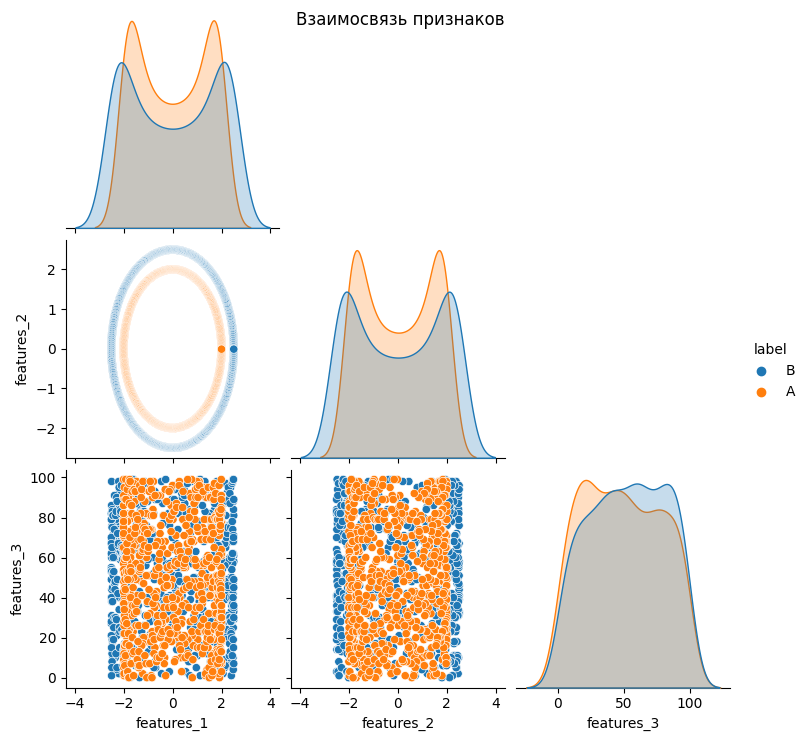

In [4]:
import seaborn as sns

sns.pairplot( #матрица диаграмм рассеяния из Seaborn
    data = df, #данные
    hue = 'label', #имя столбца с целевой переменной для раскраски меток
    corner = True #матрица симметрична, поэтому не будем выводить одинаковых графиков
).fig.suptitle( #настройка заголовка
    'Взаимосвязь признаков'
)

На графике, соответствующем признакам *features_1* и *features_2* видно, что классы хорошо разделимы окружностью.

Таким образом, мы имеем две окружности с центрами, приблизительно совпадающими с началом координат. Мы можем разделить эти окружности линейно по величине радиуса.

Сгенерируем новый признак, разделяющий объекты по радиусу окружности (предположим, что разделяющая окружность имеет центр в начале координат):

In [15]:
df["devider"] = df['features_1']**2 + df['features_2']**2
df

,features_1,features_2,features_3,label,devider
0,2.5,0.00,58,B,6.2500
1,2.5,0.02,61,B,6.2504
2,2.5,0.05,33,B,6.2525
3,2.5,0.07,89,B,6.2549
4,2.5,0.10,58,B,6.2600
...,...,...,...,...,...
1253,2.0,-0.09,30,A,4.0081
1254,2.0,-0.07,41,A,4.0049
1255,2.0,-0.05,30,A,4.0025
1256,2.0,-0.03,3,A,4.0009


Посмотрим, что у нас получилось, визуализировав взаимосвязи в данных для признаков:

Text(0.5, 0.98, 'Взаимосвязь признаков')

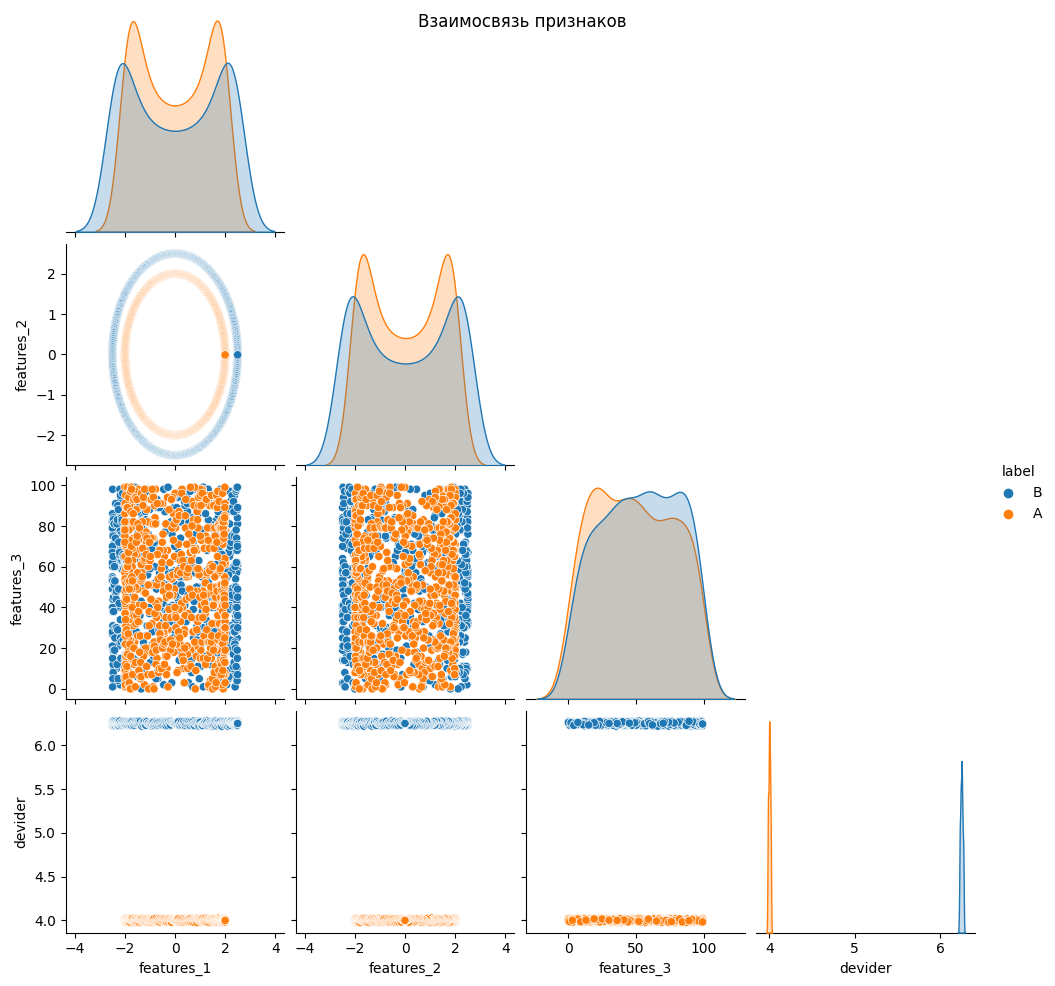

In [6]:
sns.pairplot( #матрица диаграмм рассеяния из Seaborn
    data = df, #данные
    hue = 'label', #имя столбца с целевой переменной для раскраски меток
    corner = True #матрица симметрична, поэтому не будем выводить одинаковых графиков
).fig.suptitle( #настройка заголовка
    'Взаимосвязь признаков'
)

Нижний правый график даёт понять, что теперь данные могут быть линейно разделены. И разделены они могут быть по новому признаку *devider*.

Решим задачу с новым признаком, причём в решении будем использовать только его:

In [16]:
X = df['devider'].values.reshape(-1, 1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
logRegr_model = LogisticRegression(n_jobs=-1, penalty='none')
logRegr_model.fit(X_train, y_train)
accuracy = logRegr_model.score(X_test, y_test)

print(f"Точность модели на тестовых данных составила {accuracy:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Точность модели на тестовых данных составила 1.000


Итого, получили 100% точность.

### 5. Выводы

В процессе выполнения работы был проведён процесс Feature Engineering-а. Было выяснено, что решить задачу "в лоб" получается далеко не всегда. Для построения качественной модели необходимо предварительно провести тщательный анализ данных, чтобы выявить имеющиеся закономерности или аномалии в данных.

В качестве задачи рассматривалась задача бинарной классификации. В результате исследования данных на возможные зависимости было выявлено, что данные двух классов линейно разделимы. Для разделения был создан новый признак, который позволил чётко разделить объекты обоих классов. В качестве модели использовалась модель логистической регрессии.